# Welcome to PyTorch!
The purpose of this little tutorial is to introduce you to the basics of the pytorch deep learning package, and how to structure a small project.
We will use a classic deep learning introductory problem, classification of single hand writen digets from the MNIST databse (Modified National Institute of Standars and Technology database).


## 0) First lets import torch and check if our workstation has cuda enabled GPU available. 

In [1]:
# import numpy as np
import torch as torch # import the pytorch library
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # if a cuda enabled GPU device is available get a handle(?) to it, otherwise create a handle to the cpu
device 

device(type='cuda')

## 1) Download MNIST data from the torchvision library. Torchvision needs to be imported separatly. 

In [2]:
## Loading data
from torchvision import datasets
from torchvision.transforms import ToTensor

# pytorch has several datasets you can download, including the MNIST hand writen digit
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True          
)



Above we have downloaded the training set. Fill out the code below to to download the test_set.

In [3]:
test_data = datasets.MNIST(
    root = 'data', #! cut
    train = False, #! cut
    transform = ToTensor(), #! cut
    download = True #! cut
)

## 1.1) Lets have a look at the dataset we've just downloaded

The MNIST data is composed of images and corresponding labels.
To plot an example of the data we will use matplotlib.

In [4]:
# print your 
print(train_data) 
print(test_data)

# call ne example of an image and its label. What are the dimensions of the image and what is the label for this exampel?
img, label = train_data[0] #! cut
print(img.shape) #! cut
print(label) #! cut


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([1, 28, 28])
5


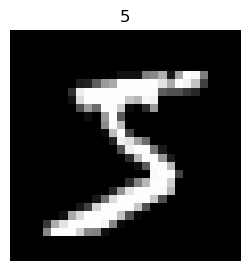

In [5]:
# plot the example image 
import matplotlib.pyplot as plt;
figure = plt.figure(figsize=(3, 3))
plt.imshow(img.squeeze(), cmap="gray") #! cut
plt.title(label)
plt.axis("off");

## 1.2) Loading your own data

Above we downloaded an existing dataset from torchvision. In many cases you will want to import your own data from .mat, .npy and .npz files. Below is an example of how that might work.

In [6]:
## save MNIST data as numpy arrays
# import numpy as np

# imgs = train_data.data.detach().numpy()
# labels = train_data.targets.detach().numpy()
# np.savez('MNIST_train.npz',imgs=imgs,labels=labels)

# imgs = test_data.data.detach().numpy()
# labels = test_data.targets.detach().numpy()
# np.savez('MNIST_test.npz',imgs=imgs,labels=labels)


In [7]:
# Loading from disk
import numpy as np

data = np.load('MNIST_train.npz') # load data from .npz file
labels=data['labels']
imgs=data['imgs'] 
imgs=torch.from_numpy(imgs) # convert numpy array to torch tensor
imgs=imgs.to(torch.float32) # specify dtype as float32 (dtype must match the model dtype whos default is usually float32)
train_data = torch.utils.data.TensorDataset(imgs,torch.from_numpy(labels))

# same thing for the test set
data = np.load('MNIST_test.npz')
imgs=torch.from_numpy(data['imgs']).to(torch.float32)
labels=data['labels']
test_data = torch.utils.data.TensorDataset(imgs,torch.from_numpy(labels))

# 1.3) create a dataloader

DataLoaders wrap an iterable around a DataSet class. This proves an easy way of sampling from the dataset in an efficeint way. This is also where we can specifiy the batchsize, as well as introduce data transforms that can be applied each time we sample from the data.

-> batch size: The size of your data sample used for each optimization step. This is a hyperparameter, e.i. a variable you can optimize to improve good model performance quickly.

-> transfomrs: We might need to rescale our images. Or we would like to augment our training data, e.g. by flipping the images horizontally or introducing noise.

In [8]:
# setup Data loader 

batchsize = 64 # This is usually a multiple of 2 between 16 and 512 and will depend on your CPU/GPU size

from torch.utils.data import DataLoader
loaders = { # Library of dataloader functions
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=batchsize, 
                                          shuffle=True, # We usually want to randomly sample a new subset of our data
                                          num_workers=1), # This variable allows us to multithread dataloading, 
                                                          # which is usefull if we have a dataset which does not fit onto the RAM
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=batchsize, 
                                          shuffle=True, 
                                          num_workers=1),
}



Lets call the dataloader to call one batch and plot the examples in that batch. We have writen a plotting function that plots a few exampels with labels in one figure for you.

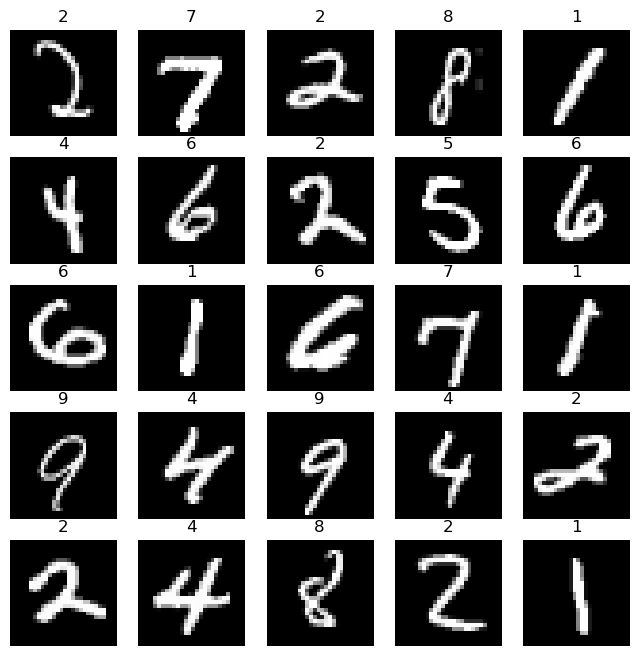

In [9]:
training_data_iterable = iter(loaders['train']) # create an iterable 
img,label=next(training_data_iterable) # calls the first randomly sampled batch of examples

import plot_examples 
plot_examples.plot(img,label,[]) # plots a few examples

# 2) Create or call a model
This is the fun bit! We have writen up a couple of models in this tutorial for you and for now we will just use one of these, but feel free to go back and modify one of them or make another one from scratch. 

In this digit classification excersize the major constraints of your model are the size of the input layer, which needs to match your input data (c\*h\*w => 1\*28\*28), and the size of your output layer, which needs to match the number of possible classes/lables (0-9 => 10). 

#### Feed Forward Models

-> LFF: No hidden layers. This is a linear model because it cannot learn nonlinear relationships.

-> DFF_tiny: This model has 10 hidden units

-> DFF: Still a fairly shallow model (not many hidden layers), but with more hidden units

#### Convolutional Models (not implemented yet)

-> ConvNet1: The first two layers are convolutional layers, which is then followed by one fully connected feed forward layer

We will use the DFF model for our example

In [19]:
from torchsummary import summary 
import Models as models 
from importlib import reload  
reload(models)# This reloads the current DFF model, even if we already loaded an older version. 

net = models.DFF().to(device) # Call an instance one of the models. 

summary(net, (1,28,28)) # this gives us a convenient way of quickly looking at the structure and size of our model. 

# We will want to cellect the model performance as we train it. So let's initiate this list here
loss_train=[] # loss collector
loss_test=[]


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 196]                 153,860
├─Linear: 1-2                            [-1, 49]                  9,653
├─Linear: 1-3                            [-1, 10]                  500
Total params: 164,013
Trainable params: 164,013
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.63
Estimated Total Size (MB): 0.63


It is often usefull to visualize our models in the form of flow charts, especially when they get large and complicated. There are several tools you can use. Try using the Netron online app. You will need to generate a .onnx file to do this. Drag-and-drop the .onnx file into the web app.

In [20]:
# Some standard imports
import torch.onnx

img,label=next(iter(loaders['train'])) # get a batch
torch.onnx.export(net,img.to(device),'MNIST_DFF.onnx',export_params=True,input_names = ['image'],output_names = ['label'],
                  dynamic_axes={'image' : {0 : 'batch_size'},'label' : {0 : 'batch_size'}}) 
# load file into https://netron.app/

## 3) Helper functions for training
We will want to create a couple helper functions to train and evaluate our model. 

-> loss function: This calculates the difference between the predicted labels and the true labels across your batch. There are many loss functions, but usually there is a standard loss function for the problem you are working on. For Classification, Cross Entropy is commonly used. This loss is then used to caculate the gradient across the model, which in turn is used to update the weights and biases in the model in a process called gradient decent.

-> gradient calculater: just kidding! Pytorch takes care of this for you. 

-> optimizer: After we calculate the loss, we need to apply gradient decent. The aim is to decrease the loss. However, there are a number of ways this can be applied. We therefore need to choose a optimizer function.

-> accuracy: We usually also want to know the proportion of correctly identified examples. This is not usefull for gradient decent.

-> Wrapper: It is helpfull to write a function, which applies the above steps in the correct order and only when appropriate (e.g. you should disable optimization when applying your model to test data).  

In [21]:
## Loss function
from torch import nn

loss = nn.CrossEntropyLoss()
# loss = nn.MSELoss() # Alternative: would need to convert label to on-hot-vector -> nn.functional.one_hot(label,num_classes=10)


In [22]:
## accuracy
import numpy as np

def accuracy_calc(labels,labels_pred_int): 
    # labels: true labels (in integer from, not a one-hot-vector)
    # labels_pred_int: predicted labels (in integer from, not a vector of probabilities)
    labels = labels.cpu().detach().numpy() # to use numpy we need to move the tensor of labels off the GPU and convert it to a numpy array
    labels_pred_int = labels_pred_int.cpu().detach().numpy()
    return 100*(labels_pred_int == labels).sum().item() / np.shape(labels)[0] # Here, we calculate the percent correctly predicted labels

There are a number of different optimization algorithms and components there of. 

-> Batch gradient decent: caculate the gradient across the entire training data set and then perform one optimization step.

-> Stocastic gradient decent (SGD): caucluate the gradient and apply an optimization step for each training sample independently.

-> Mini-batch gradient decent: for each batch (e.g. 32 training examples) caculate the gradient and apply one step of optimization. Usually preferable of the Batch gradient decent or true SGD.

-> Momentum: uses a rolling average of the gradient, so that noise across batches is minimized. This smooths the learning "trajectory".

-> Adaptive learning rate: when we are far away from the global optimum a larger learning rate is advantages as it speeds up progress, but as we approach the global minimum small steps are better. 

Note: confusingly the pytorch function torch.optim.SGD does not perform Stocastic gradient decent strictly speaking. It will optimize based on the accumulated gradient, of which the step size is defined by us. You will see what this means below. 

In [23]:
## optimizer
from torch import optim

# We will use 
lr = 0.01 
momentum = 0 # try 0.5
optimizer = optim.SGD(net.parameters(),momentum=momentum,lr=lr) # stocastic gradient decent
# optimizer = optim.Adam(net.parameters()) # more advanced alternative


Let's wrap things up!

In [24]:
## Wrapper function
def run_model(img,labels,model,optimizer,Loss,train=False):
    if train: # only important in specific instances (e.g. if your model has dropout layers or variational layers)
        model.train()
    else:
        model.eval()
    
    optimizer.zero_grad() # othewise gradients will accumulate. 

    labels_pred = model(img)  # run model and get label predictions
    labels_pred_int = labels_pred.argmax(axis=1) # our model spits out a probability for each category to be true. This line gets the index of max porbablity for each example.
    loss = Loss(labels_pred,labels) # calcualte the loss (only uses one channel)
    accuracy = accuracy_calc(labels,labels_pred_int) # caculate the % correct predictions

    # we only want this next bit to be true when specified, i.e. when we are training the model
    if train:
        # backprob and update
        loss.backward() # calculates the gradient based on the current loss
        optimizer.step() # applies one optimization step
    
    return loss, labels_pred, labels_pred_int, accuracy



It's a good idea to check things are working before training your model. Get a training example batch, run it through the model using the wrapper function above and print the outs.

In [25]:
# check its all working
img,label=next(iter(loaders['train'])) #! cut # get a batch
img = img.to(device) #! cut
label = label.to(device) #! cut 
batch_loss, label_pred, label_pred_int, accuracy = run_model(img,label,net,optimizer,loss) #! cut

label=label.cpu().detach().numpy()
batch_loss=batch_loss.cpu().detach().numpy()
label_pred=label_pred.cpu().detach().numpy()
label_pred_int=label_pred_int.cpu().detach().numpy()

print('label:            ' + np.array2string(label))
print('label prediction: ' + np.array2string(label_pred_int))
print('label weights first example: ' + np.array2string(label_pred[0]*100,precision=0,suppress_small=True))
print('loss: ' + np.array2string(batch_loss))
print('accuracy: ' + str(accuracy) + '%')


label:            [8 9 9 6 1 4 2 6 2 1 9 8 4 9 0 4 5 3 0 1 6 9 5 9 0 3 4 3 9 6 4 5 2 0 7 3 3
 9 6 5 4 6 2 6 7 1 0 7 8 7 7 9 9 0 8 9 6 2 9 9 7 1 4 8]
label prediction: [8 3 1 9 2 1 7 3 7 9 3 1 1 8 0 3 9 8 3 1 2 3 3 9 8 8 8 9 3 7 3 3 3 0 9 1 8
 3 1 1 3 7 1 9 3 2 1 2 9 3 3 3 9 3 8 1 1 0 3 3 3 8 7 3]
label weights first example: [ 0.  0.  0.  0.  0.  0.  0.  0. 99.  1.]
loss: 2.3021722
accuracy: 10.9375%


## 4) Training time

It's finnaly time to train our model. We will do this using two for loops. The nested loop will sample batches of data and optimize the model on each itteration untill all examples in the training set have been used once. The second loop will repeate these passes over the training set a given number of times (epochs) as well as caculate and plot the loss for the training and test set at the end of each epoch.

But first lets caculate the training and test loss before any optimization has occured.

In [26]:
if len(loss_train)<1: # if no training has happened yet save initial loss value
    img,label=next(iter(loaders['train'])) # get one batch
    img = img.to(device)
    label = label.to(device)
    batch_loss, _, _, _ = run_model(img,label,net,optimizer,loss)
    loss_train.append(batch_loss.cpu().detach().numpy())

if len(loss_test)<1: # if no training has happened yet save initial loss value
    img,label=next(iter(loaders['test'])) # get one batch
    img = img.to(device)
    label = label.to(device)
    batch_loss, _, _, _ = run_model(img,label,net,optimizer,loss)
    loss_test.append(batch_loss.cpu().detach().numpy())

We will use tqdm (giving us a progress bar) to keep track of the progress through the training set.

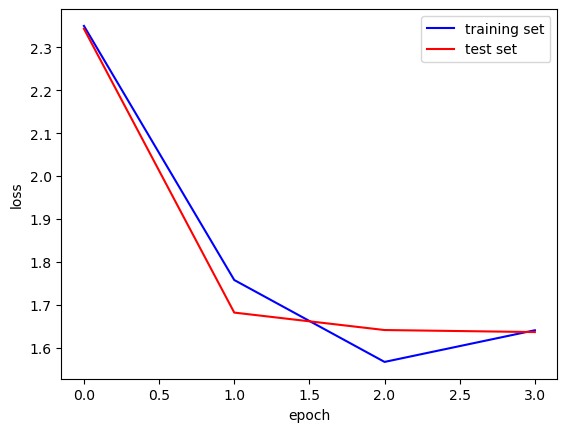

100%|██████████| 938/938 [00:06<00:00, 142.93it/s]


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002972316B550> (for post_execute):


IndexError: list index out of range

IndexError: list index out of range

<Figure size 640x480 with 1 Axes>

In [27]:
from tqdm import tqdm
from IPython import display

# training loop
epochs = 30 # 

plt.figure()
for ep_n in range(epochs):

    for img,label in tqdm(loaders['train']):
        img = img.to(device)
        label = label.to(device)
        net.train()
        run_model(img,label,net,optimizer,loss,train=True)

    # train set loss
    img,label=next(iter(loaders['train'])) # get a batch
    img = img.to(device)
    label = label.to(device)
    batch_loss, _, _, _ = run_model(img,label,net,optimizer,loss)
    loss_train.append(batch_loss.cpu().detach().numpy())

    # test set loss
    img,label=next(iter(loaders['test'])) # get a batch
    img = img.to(device)
    label = label.to(device)
    batch_loss, _, _, _ = run_model(img,label,net,optimizer,loss)
    loss_test.append(batch_loss.cpu().detach().numpy())

    # plot the losses
    plt.clf()
    train_handle = plt.plot(loss_train, color='blue',label='training set')
    test_handle = plt.plot(loss_test, color='red',label='test set')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    display.clear_output(wait=True) # necessary in order to refresh the plot, otherwise it will print a new plot each epoch
    display.display(plt.gcf())
        
    

## 5) Evaluating performance

If all has gone well our loss function should have decreased substantially and reached a platough. Or you've gotten board, cut the training of early and would just like to see how well the model is doing right now.

To get a feeling of for the models performance we will get multiple batches of test data, caculate the classificiation accuracy of the this set and then plot a few examples.

label: [1 7 9 1 1 3 7 2 0 9 9 2 1 2 1 5 2 4 1 9 4 8 4 6 1 5 9 8 3 6 7]
label prediction: [1 7 9 1 1 3 7 2 0 9 9 2 1 2 1 5 2 4 1 9 4 8 4 6 1 5 9 8 3 6 7]
label weights first example: [  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]
loss: 1.4884319
accuracy: 97.59%


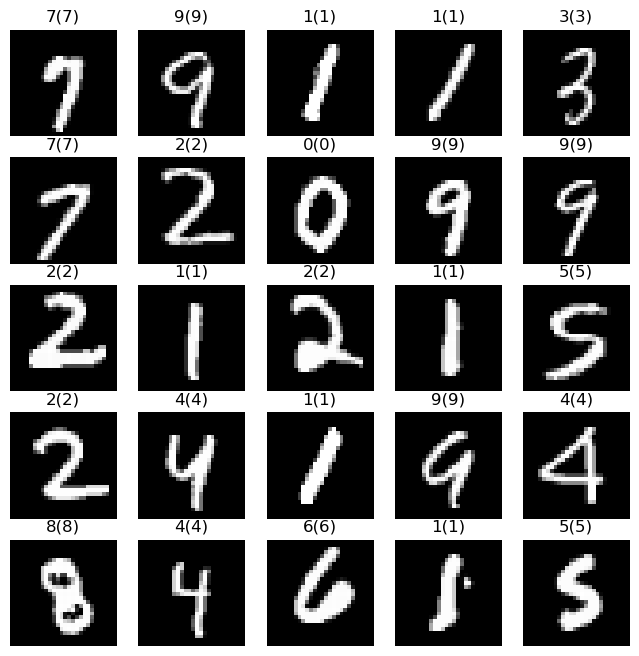

In [ ]:
# check its all working
loader_temp = iter(loaders['test'])
img,label = next(loader_temp) # get a batch
for i in range(10): # get multiple batches to get more accurate estimates
    img_temp, label_temp = next(loader_temp)
    img=torch.cat((img,img_temp),dim=0)
    label=torch.cat((label,label_temp),dim=0)
img = img.to(device)
label = label.to(device)
batch_loss, label_pred, label_pred_int, accuracy = run_model(img,label,net,optimizer,loss)


img=img.cpu().detach().numpy()
label=label.cpu().detach().numpy()
batch_loss=batch_loss.cpu().detach().numpy()
label_pred=label_pred.cpu().detach().numpy()
label_pred_int=label_pred_int.cpu().detach().numpy()

print('label: ' + np.array2string(label[0:31]))
print('label prediction: ' + np.array2string(label_pred_int[0:31]))
print('label weights first example: ' + np.array2string(label_pred[0]*100,precision=0,suppress_small=True))
print('loss: ' + np.array2string(batch_loss))
print('accuracy: ' + str(round(accuracy, 2)) + '%')

plot_examples.plot(img,label,label_pred_int)

## 6) Saving and re-loading models

Now that we have a model that performs reasonably well, we want to save it. When you save models you save two things separatly 1) the architecture, which we is already saved, e.g. DFF.py, 2) the model weights, or state.

In [ ]:
torch.save(net.state_dict(), '/PytorchTutorial/MNIST_DFF1.pt')

When we want to retreave a trained model we also need to recover it in two stages.

In [ ]:
#load model 
from Models import DFF as model# try DFF
net2 = model().to(device)

# load weights into model
net2.load_state_dict(torch.load('/PytorchTutorial/MNIST_DFF1.pt'))
# net2.load_state_dict(torch.load('/PytorchTutorial/MNIST_DFF_pretrained.pt')) # or a model we prepared earlier

<All keys matched successfully>

# The End